# <span style="color:#F72585"><center>Introducción a subclassing y a la API funcional de Keras</center></span>

<figure>
<center>
<img src="https://raw.githubusercontent.com/AprendizajeProfundo/Alejandria/main/Redes_Neuronales/Imagenes/Funcional.JPG" width="700" height="400" align="center" /> 
</center>   
</figure>
<center>

Fuente: <a href="https://commons.wikimedia.org/wiki/File:Functional_group_with_sulfur_compounds_sulfone_sulfonic_acid_sulfonamide_2.JPG">Bin im Garten</a>, <a href="https://creativecommons.org/licenses/by-sa/3.0">CC BY-SA 3.0</a>, via Wikimedia Commons

</center>

## <span style="color:#4361EE">Introducción</span>

Est lección es basada en un notebook de Google Colaboratory. Los programas de Python se ejecutan directamente en tu navegador,  una gran manera de aprender y utilizar TensorFlow. Para poder seguir este tutorial, ejecuta este notebook en Google Colab. Basado en [Tensorflow- quick start expertos](https://www.tensorflow.org/tutorials/quickstart/advanced)

## <span style="color:#4361EE">Sobre los datos MNIST</span> 

<figure>
<center>
<img src="https://raw.githubusercontent.com/AprendizajeProfundo/Alejandria/main/Redes_Neuronales/Imagenes/mnist.png" width="700" height="400" align="center" /> 
</center>   
</figure>
<center>

Fuente: <a href="https://commons.wikimedia.org/wiki/File:MnistExamples.png">Josef Steppan</a>, <a href="https://creativecommons.org/licenses/by-sa/4.0">CC BY-SA 4.0</a>, via Wikimedia Commons

Tomado de [Wikipedia](https://en.wikipedia.org/wiki/MNIST_database). La base de datos MNIST (Base de datos modificada del Instituto Nacional de Estándares y Tecnología es una gran base de datos de dígitos escritos a mano que se usa comúnmente para entrenar varios sistemas de procesamiento de imágenes. La base de datos también se usa ampliamente para entrenamiento y pruebas en el campo del aprendizaje automático. Fue creado "volviendo a mezclar" las muestras de los conjuntos de datos originales del NIST. Los creadores sintieron que, dado que el conjunto de datos de entrenamiento del NIST se tomó de los empleados de la Oficina del Censo de los Estados Unidos, mientras que el conjunto de datos de prueba se tomó de los estudiantes de secundaria estadounidenses, no era adecuado para los experimentos de aprendizaje automático. Además, las imágenes en blanco y negro del NIST se normalizaron para encajar en un cuadro delimitador de 28x28 píxeles y se suavizaron, lo que introdujo niveles de escala de grises.

La base de datos del MNIST contiene 60 000 imágenes de entrenamiento y 10 000 imágenes de prueba. La mitad del conjunto de entrenamiento y la mitad del conjunto de prueba se tomaron del conjunto de datos de entrenamiento del NIST, mientras que la otra mitad del conjunto de entrenamiento y la otra mitad del conjunto de prueba se tomaron del conjunto de datos de prueba del NIST. Los creadores originales de la base de datos mantienen una lista de algunos de los métodos probados en ella. En su artículo original, utilizan una máquina de vectores de soporte para obtener una tasa de error del 0,8 %.

En nuestro ejemplo, tomaremos los datos de los ejmeplos de keras en `tensorflow.keras.datasets`.

## <span style="color:#4361EE">Importa librerías</span> 

In [76]:

import tensorflow as tf
print('Version de Tensorflow = ', tf.__version__)

# Objetos de la API de Keras
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

# datos mnist
from tensorflow.keras.datasets import mnist

# Manejo de datasets como tensores de tf
dataset = tf.data.Dataset.from_tensor_slices

# Métricas para medir pérdida y precisión
loss_metric     = tf.keras.metrics.Mean
accuracy_metric = tf.keras.metrics.SparseCategoricalAccuracy

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import pandas as pd
import matplotlib
import numpy as np
import seaborn as sns

Version de Tensorflow =  2.4.1


## <span style="color:#4361EE">Prepara datos de MNIST</span> 

In [24]:
# carga los datos en areglos de numpy
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train/255.0, x_test/255.0

# Crea un subconjunto de validación interna
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.20, random_state=100)

In [38]:
y_test.shape

(10000,)

In [25]:
print('Tamaños train: X = {}, y = {}'.format(x_train.shape, y_train.shape))
print('Tamaños validación: X = {}, y = {}'.format(x_val.shape, y_val.shape))
print('Tamaños prueba: X = {}, y = {}'.format(x_test.shape, y_test.shape))

Tamaños train: X = (48000, 28, 28), y = (48000,)
Tamaños validación: X = (12000, 28, 28), y = (12000,)
Tamaños prueba: X = (10000, 28, 28), y = (10000,)


In [26]:
# Agrega una dimensión en el input para manejo de canales de imágenes en tensorflow
x_train = x_train[...,tf.newaxis]
x_val = x_val[...,tf.newaxis]
x_test = x_test[...,tf.newaxis]

In [27]:
print('Forma de x_train:', x_train.shape)
print('Forma de x_test:', x_val.shape)
print('Forma de x_test:', x_test.shape)

Forma de x_train: (48000, 28, 28, 1)
Forma de x_test: (12000, 28, 28, 1)
Forma de x_test: (10000, 28, 28, 1)


## <span style="color:#4361EE">Separa lotes de datos  y mezclar el conjunto de datos</span>

Usamos *tf.data*.  Revise cuidadosamente el tutorial  [tf.data: compila canalizaciones de entrada de TensorFlow](https://www.tensorflow.org/guide/data)

In [28]:
train_ds = dataset((x_train, y_train)).shuffle(10000).batch(32)
val_ds  = dataset((x_val, y_val)).shuffle(10000).batch(32)
test_ds  = dataset((x_test, y_test)).shuffle(10000).batch(32)

In [33]:
print(train_ds)
print(val_ds)
print(test_ds)
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

<BatchDataset shapes: ((None, 28, 28, 1), (None,)), types: (tf.float64, tf.uint8)>
<BatchDataset shapes: ((None, 28, 28, 1), (None,)), types: (tf.float64, tf.uint8)>
<BatchDataset shapes: ((None, 28, 28, 1), (None,)), types: (tf.float64, tf.uint8)>
1500
375
313


## <span style="color:#4361EE">API Funcional de Keras. Sub-clases</span>

Vamos a derivar nuestro model de la clase Model de la API funcional de Keras.

In [7]:
class MNIST_Model(Model):
    def __init__(self):
        super(MNIST_Model,self).__init__()
        self.conv1 = Conv2D(32, 3, activation='relu')
        self.flatten= Flatten()
        self.d1 = Dense(128, activation='relu')
        self.d2 = Dense(10, activation='softmax')
    
    def call(self,x):
        x = self.conv1(x)
        x = self.flatten(x)
        x = self.d1(x)
        return self.d2(x)

# crea una instancia del modelo
model_mnist = MNIST_Model()

## <span style="color:#4361EE">Compila</span>


In [43]:
#configura obetos para entrenamiento
optimizer = tf.keras.optimizers.Adam(0.001)
metrics = ['accuracy']
loss = SparseCategoricalCrossentropy()

# compila el modelo
model_mnist.compile(optimizer=optimizer,
                    loss=loss,
                    metrics=metrics)

## <span style="color:#4361EE">Entrena</span>


In [44]:
epochs = 5
validation_split = 0.2

history = model_mnist.fit(train_ds,
                    epochs=epochs,
                    validation_data=val_ds)

Epoch 1/5


2022-12-07 11:15:26.870981: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-12-07 11:15:26.891230: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2694965000 Hz


1500/1500 [==============================] - 110s 71ms/step - loss: 0.2873 - accuracy: 0.9121 - val_loss: 0.0765 - val_accuracy: 0.9766
Epoch 2/5
1500/1500 [==============================] - 109s 72ms/step - loss: 0.0527 - accuracy: 0.9831 - val_loss: 0.0618 - val_accuracy: 0.9835
Epoch 3/5
1500/1500 [==============================] - 112s 74ms/step - loss: 0.0264 - accuracy: 0.9915 - val_loss: 0.0590 - val_accuracy: 0.9838
Epoch 4/5
1500/1500 [==============================] - 113s 75ms/step - loss: 0.0156 - accuracy: 0.9948 - val_loss: 0.0712 - val_accuracy: 0.9813
Epoch 5/5
1500/1500 [==============================] - 114s 76ms/step - loss: 0.0114 - accuracy: 0.9961 - val_loss: 0.0658 - val_accuracy: 0.9841


In [6]:
model_iris.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## <span style="color:#4361EE">Arquitectura del modelo</span>

Model: "mnist__model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  320       
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  2769024   
_________________________________________________________________
dense_1 (Dense)              multiple                  1290      
Total params: 2,770,634
Trainable params: 2,770,634
Non-trainable params: 0
_________________________________________________________________


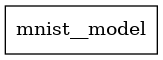

In [45]:
model_mnist.summary()
plot_model(model_mnist, to_file='../Imagenes/mnist_model.png', 
           show_shapes=True)

## <span style="color:#4361EE">Evaluación del entrenamiento</span>

In [53]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
0,0.152810,0.953583,0.076471,0.976583,0
1,0.046672,0.985187,0.061765,0.983500,1
2,0.025305,0.991521,0.059041,0.983833,2
3,0.014654,0.995167,0.071229,0.981333,3
4,0.011462,0.996083,0.065816,0.984083,4


Revisemos la gráficas de entrenamiento

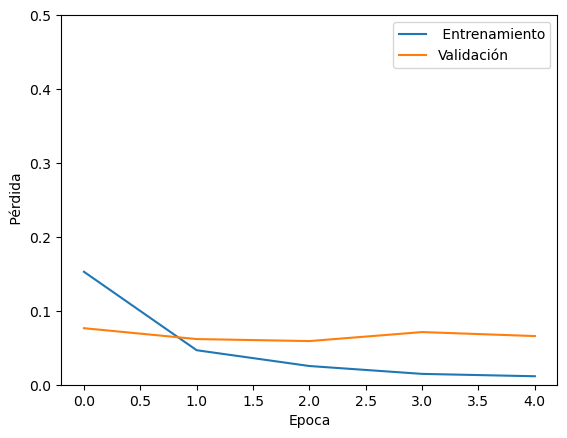

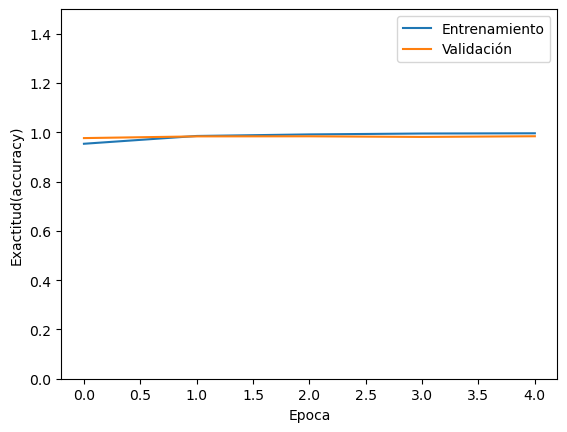

In [58]:
# función para mostrar pérdida y métricas
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['Epoca'] = history.epoch

    plt.figure()
    plt.xlabel('Epoca')
    plt.ylabel(' Pérdida')
    plt.plot(hist['Epoca'], hist['loss'],
           label=' Entrenamiento')
    plt.plot(hist['Epoca'], hist['val_loss'],
           label = 'Validación')
    plt.ylim([0,0.5])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoca')
    plt.ylabel('Exactitud(accuracy)')
    plt.plot(hist['Epoca'], hist['accuracy'],
           label='Entrenamiento')
    plt.plot(hist['Epoca'], hist['val_accuracy'],
           label = 'Validación')
    plt.ylim([0,1.5])
    plt.legend()
    plt.show()


plot_history(history)

## <span style="color:#4361EE">Evaluación del modelo</span>

In [60]:
print("Evaluación del modelo con datos de prueba")
results = model_mnist.evaluate(test_ds)
print("\n test loss, test acc:", results)

Evaluación del modelo con datos de prueba
313/313 [==============================] - 6s 19ms/step - loss: 0.0593 - accuracy: 0.9836

 test loss, test acc: [0.0592704638838768, 0.9836000204086304]


O lo que es lo mismo

## <span style="color:#4361EE">Predicciones del modelo</span>

In [67]:
# Generar predicciones (probabilidades -- el resultado de la última capa)
# sobre nuevos datos usando `predict`
print("Genera predicciones para cuatro muestras")
predicciones = model_mnist.predict(x_test[:3])
print("Predicciones:\n", np.round(predicciones,3))

# clase predicha
y_pred_c = np.argmax(predicciones, axis=1)
print('\n Clase predicha: ', y_pred_c )

Genera predicciones para cuatro muestras
Predicciones:
 [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

 Clase predicha:  [7 2 1]


## <span style="color:#4361EE">Matriz de confusión con datos de prueba</span>


In [74]:
y_pred = np.argmax(model_mnist.predict(x_test), axis=1)

cm = confusion_matrix(y_test, y_pred)

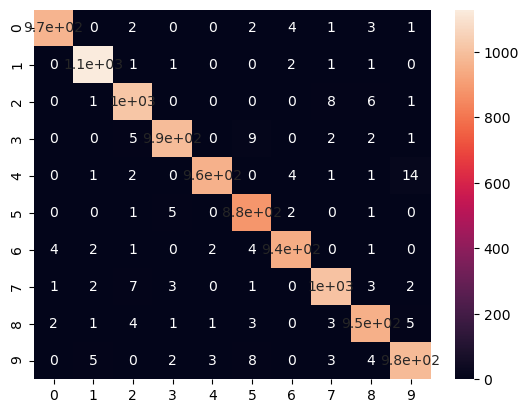

In [77]:
sns.heatmap(cm,annot=True)
plt.savefig('h.png')

## <span style="color:#4361EE">Ejercicio</span>

1. Muestre la imagen de los dígitos a mano alzada usados en la última predicción. Adicione la etiqueta de la imagen y la predicción.
1. Pruebe la siguiente funcipon que permite separar datos en un objeto `tf.data`. Explique los detalles.

In [ ]:
def get_dataset_partitions_tf(ds, ds_size, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    if shuffle:
        # Especificar semilla para tener siempre la misma distribución dividida entre ejecuciones
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds